# Cross validation analysis of final evaluation results between different techniques

Tong Shu Li<br>
Created on: 2015-10-08<br>
Last updated: 2015-10-08

The team at UTexas was kind enough to send their final predictions for the CID task. We will compare their results to the crowd's and see where their outputs differed.

In [1]:
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys

In [2]:
%matplotlib inline

In [3]:
sys.path.append("..")

In [4]:
from src.lingpipe.file_util import read_file
from src.data_model import Ontology_ID
from src.eval_perf import performance

---

### Read the gold standard and output files

In [5]:
def read_output(fname):
    temp = defaultdict(list)
    for line in read_file(fname):
        vals = line.split("\t")
        
        if len(vals) > 1 and vals[1] == "CID":
            temp["pmid"].append(int(vals[0]))
            temp["chemical_id"].append(Ontology_ID(vals[2]).flat_repr)
            temp["disease_id"].append(Ontology_ID(vals[3]).flat_repr)
            
            if len(vals) > 4:
                temp["threshold"].append(float(vals[4]))

    return pd.DataFrame(temp)

In [6]:
fname = os.path.abspath(os.path.join("..", "data", "gold_standard", "CDR_TestSet.txt"))
gold_std = read_output(fname)

In [7]:
run = dict()
for i in range(1, 6):
    fname = os.path.abspath(os.path.join("..", "data", "utexas", "CDR_TestSet.Predict.Run{}.txt".format(i)))
    run[i] = read_output(fname)

---

### Compare results of each run with gold

In [8]:
def get_triples(dataframe):
    return set(dataframe[["pmid", "chemical_id", "disease_id"]].apply(
                lambda row: (int(row["pmid"]), row["chemical_id"], row["disease_id"]), axis = 1))

In [9]:
gold_triples = get_triples(gold_std)

In [10]:
def official_F_score(score_column, gold_rel_set, dataframe):
    EPSILON = 0.0000001
    
    res = defaultdict(list)
    for threshold in dataframe[score_column].unique():
        sub = dataframe.query("{0} > {1} or -{2} <= {0} - {1} <= {2}".format(score_column, threshold, EPSILON))
        
        # grab the relation ids we guessed
        predict = get_triples(sub)
        
        precision, recall, f1 = performance(gold_rel_set, predict)
        
        res["recall"].append(recall)
        res["precision"].append(precision)
        res["threshold"].append(threshold)
        res["F_score"].append(f1)
        
    return pd.DataFrame(res)

In [11]:
perf = dict()
for i in range(1, 6):
    perf[i] = official_F_score("threshold", gold_triples, run[i])
    perf[i].loc[:, "run"] = i

In [12]:
pd.concat([perf[i] for i in range(1, 6)])

,F_score,precision,recall,threshold,run
0,0.535585,0.750000,0.416510,0.75,1
1,0.668884,0.677575,0.660413,0.65,1
2,0.669395,0.649603,0.690432,0.30,1
0,0.605904,0.676301,0.548780,0.75,2
1,0.671566,0.657966,0.685741,0.65,2
2,0.670194,0.632280,0.712946,0.30,2
0,0.443982,0.324924,0.700750,0.75,3
1,0.488914,0.348819,0.817073,0.65,3
2,0.489624,0.349200,0.818949,0.30,3
0,0.536703,0.748322,0.418386,0.75,4


In [13]:
def plot_results(res, title, xlabel, fontsize, figsize, linewidth, fname = None):
    res = res.sort("threshold")
    matplotlib.rcParams.update({'font.size': fontsize})

    graph = res.plot(x = "threshold", figsize = figsize,
                     linewidth = linewidth, title = title)
    graph.set_ylim((0, 1.1))
    graph.set_xlabel(xlabel)
    
    if fname is not None:
        plt.savefig(fname, bbox_inches = "tight")

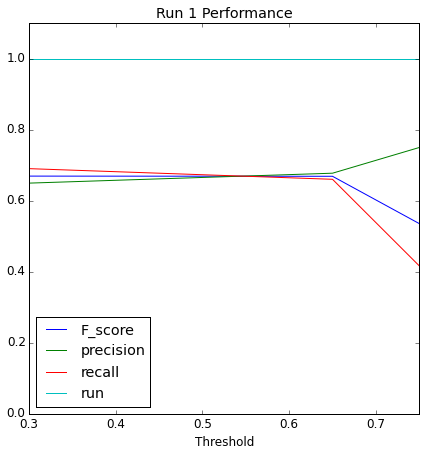

In [14]:
plot_results(perf[1], "Run 1 Performance", "Threshold", 12, (7, 7), 1)

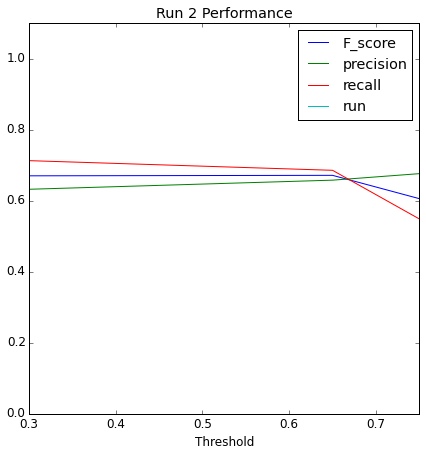

In [15]:
plot_results(perf[2], "Run 2 Performance", "Threshold", 12, (7, 7), 1)

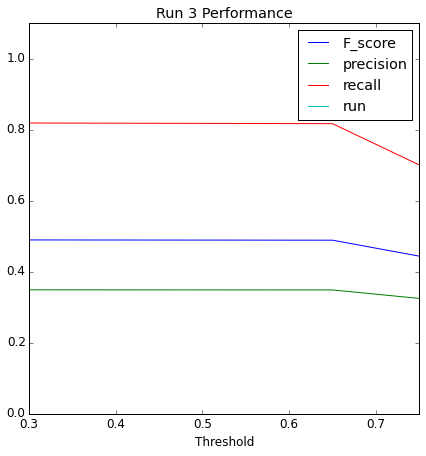

In [16]:
plot_results(perf[3], "Run 3 Performance", "Threshold", 12, (7, 7), 1)

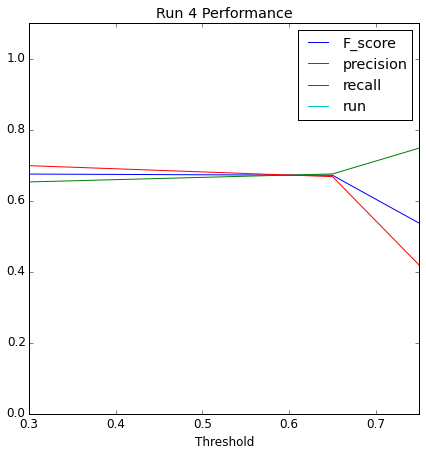

In [17]:
plot_results(perf[4], "Run 4 Performance", "Threshold", 12, (7, 7), 1)

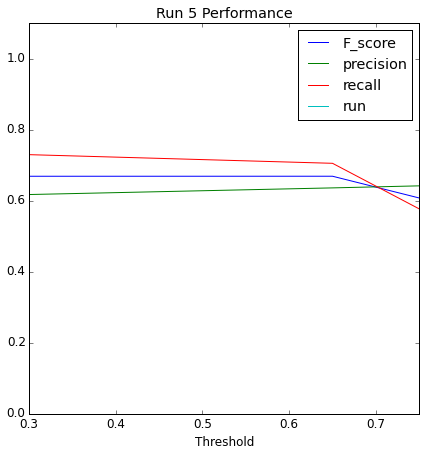

In [18]:
plot_results(perf[5], "Run 5 Performance", "Threshold", 12, (7, 7), 1)